Programa para generar sets de datos de pueba

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
import math
from multiprocessing import Pool

In [2]:
# Parámetros del modelo
Omega_r0 = 0.0
Omega_m0 = 0.30
Omega_l0 = 0.70
h0 = 70 # km / s * Mpc
P = 100 #Número de valores de redshift

Definimos las funciones necesarias

In [3]:
def Omega_k(Omega_m0, Omega_l0, Omega_r0):
    Omega_k0 = 1 - Omega_m0 - Omega_l0 - Omega_r0
    return Omega_k0

def E(x, Omega_m0,  Omega_l0,  Omega_r0):
    return np.sqrt(Omega_m0*(1+x)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+x)**2 + Omega_l0)

def IntFunct(x, Omega_m0, Omega_l0, Omega_r0):
    return E(x, Omega_m0, Omega_l0, Omega_r0)**(-1)

def integral(z, Omega_m0, Omega_l0, Omega_r0):
    return integrate.quad(IntFunct,0, z, args=(Omega_m0, Omega_l0, Omega_r0),epsabs=1.49e-4, epsrel=1.49e-03,full_output = 1)[0]

def distancia_luminosidad(z, h0, Omega_m0,  Omega_l0,  Omega_r0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0, Omega_l0, Omega_r0)
    
    if Omega_k(Omega_m0, Omega_l0, Omega_r0) < 0: # Abierto
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sin(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
    elif Omega_k(Omega_m0, Omega_l0, Omega_r0) == 0: 
        d_L = c * (1 + z) * intl / h0
    else: # Cerrado
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sinh(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
        
    return d_L

distancia_luminosidad_vec = np.vectorize(distancia_luminosidad)

Creamos el modelo

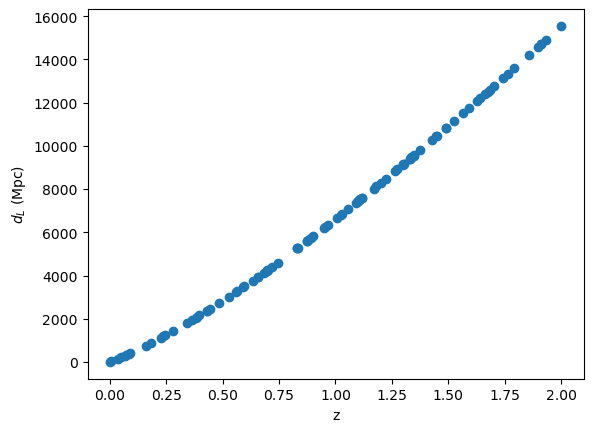

In [4]:
# Creamos un vector de P valores aleatorios de redshift entre 0 y 2
valores_z = np.sort(2 * np.random.rand(P))

# Calculamos las distancia de luminosidad de estos valores_z
with Pool() as pool:
    valores_distancia_real = [distancia_luminosidad(z, h0, Omega_m0,  Omega_l0,  Omega_r0) for z in valores_z]


plt.scatter(valores_z, valores_distancia_real)
plt.xlabel("z")
plt.ylabel("$d_L$ (Mpc)")
plt.show()

Comparamos con astropy

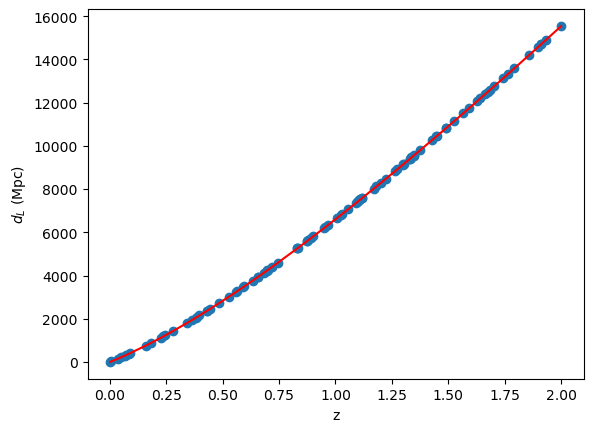

In [5]:
from astropy.cosmology import LambdaCDM

cosmo = LambdaCDM(H0 = h0, Om0 = Omega_m0, Ode0 = Omega_l0, Tcmb0 = 0)

distancias_astropy = cosmo.luminosity_distance(valores_z)


plt.scatter(valores_z, valores_distancia_real)
plt.plot(valores_z, distancias_astropy.to_value(),'r')
plt.xlabel("z")
plt.ylabel("$d_L$ (Mpc)")
plt.show()

Desviamos los datos y creamos un error gaussiano

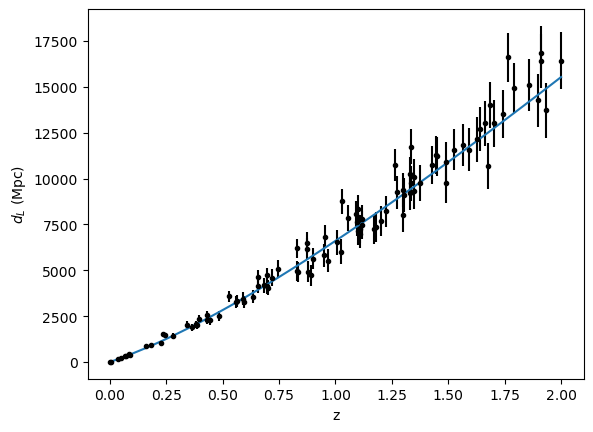

In [6]:
error_mock = 0.1*np.array(valores_distancia_real)
# Tomamos un número aleatorio a partir de una distribución normal con centro en "valores_distancia_real" y anchura (des. estándar) "error_mock"
valores_distancia_mock = np.sqrt((np.random.normal(valores_distancia_real, error_mock))**2)

plt.errorbar(valores_z, valores_distancia_mock, yerr = error_mock, fmt =  ".k", capsize = 0)
plt.plot(valores_z, distancias_astropy.to_value())
plt.xlabel("z")
plt.ylabel("$d_L$ (Mpc)")

plt.show()

Guardamos los datos en un .csv

In [7]:
np.savetxt('Datos_Mock_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', np.column_stack((valores_z, valores_distancia_mock, error_mock)), delimiter = ',')